In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

In [2]:
global_epoch_number = 30

## Reading data

In [3]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [4]:
evo_data.columns

Index(['travels', 'tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday'

In [5]:
evo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
modo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [6]:
unievo_data = pd.DataFrame(evo_data.travels)
unimodo_data = pd.DataFrame(modo_data.travels)
unic2g_data = pd.DataFrame(c2g_data.travels)

In [7]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

unievo_data = unievo_data[(unievo_data.index >= '2018-'+init_period) & (unievo_data.index <= '2018-'+end_period)]
unimodo_data = unimodo_data[(unimodo_data.index >= '2018-'+init_period) & (unimodo_data.index <= '2018-'+end_period)]
unic2g_data = unic2g_data[(unic2g_data.index >= '2017-'+init_period) & (unic2g_data.index <= '2017-'+end_period)]

## LSTM Data Preparation

In [8]:
def sup_learning_formatter(data, past_lags, future_steps, train_split):
    X = []
    y = []

    norm_data  = data.values

    for n in range(len(data) - past_lags - future_steps):
        X.append(norm_data[n : n + past_lags])
        y.append(data.travels.values[n + past_lags : n + past_lags + future_steps])
    return np.array(X), np.array(y)

In [9]:
def train_val_test_splitter(data, splits):
    print([int(len(data)*n) for n in splits])
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:], data[0].shape

In [10]:
def eval_model(y, y_hat):
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["MAE"] = mean_absolute_error(y, y_hat)
    evaluation["R2"] = r2_score(y, y_hat)

    return evaluation

In [11]:
def run_lstm(data, past_lags, future_steps, splits, node_number, epochs=10, batch_size=10000, loss='mae', layer_count=3, dropout=0.7):
    
    X, y = sup_learning_formatter(data, past_lags, future_steps, splits[0])
    X_train, X_val, X_test, X_shape = train_val_test_splitter(X, splits)
    y_train, y_val, y_test, y_shape = train_val_test_splitter(y, splits)


    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(batch_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val = val.batch(batch_size).repeat()

    model = tf.keras.models.Sequential()

    if(layer_count == 1):
        model.add(tf.keras.layers.LSTM(node_number,
                                    input_shape=X_shape))
        model.add(tf.keras.layers.Dropout(dropout))
    else:
        model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                    input_shape=X_shape))
        model.add(tf.keras.layers.Dropout(dropout/2))

        for _ in range(layer_count - 2):
            model.add(tf.keras.layers.LSTM(node_number, return_sequences=True, activation='relu'))

        model.add(tf.keras.layers.LSTM(node_number, activation='relu'))
        
    model.add(tf.keras.layers.Dense(12))
    
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss=loss, metrics=[rmse])
    
    for x, y in val.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train, epochs=epochs, steps_per_epoch=50,
                        validation_data=val, validation_steps=50
                        )

    y_hat_test = model.predict(X_test)
    print(y_hat_test[0])
    evaluation = eval_model(y_test, y_hat_test)

    return model, history, (X_test, y_test), evaluation

In [12]:
def persistance_model(X, timesteps):
    y_hat = []
    for x in X:
        y_hat.append(np.array([x[-1][0] for _ in range(timesteps)]))

    return np.array(y_hat)

# Plot Generation

In [13]:
def performance_representation_plot(hour_skip, title, y_hat, y, title_in_plot=True, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    
    
    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.show() if print_plot else print()

In [62]:
def save_performance_to_txt(name, y_hat, y, evaluation, hour_skip=12):

    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    
    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    
    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")

    json_eval = json.dumps(evaluation, indent = 4) 
    with open(f'results/LSTM_{name}_Results.json', "w") as outfile: 
        outfile.write(json_eval)

# Training Models

In [15]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction[0]), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [16]:
def plot_train_history(history, title, save_file=False):
    history = pd.DataFrame(history.history)

    history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

Next, will be generated the model for each dataset

## Evo Model

### Single Variable

In [17]:
print('Evo Model Single Var')
unievo_model, unievo_hist, unievo_test, unievo_eval = run_lstm(unievo_data, 24, 12, (0.6, 0.8), 60,
                                                               epochs=global_epoch_number, dropout=0.5, layer_count = 5)

Evo Model Single Var
[136, 181]
[136, 181]
(45, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 12s 244ms/step - loss: 221.5837 - rmse: 302.1095 - val_loss: 160.9617 - val_rmse: 182.6437
Epoch 2/30
50/50 [==============================] - 6s 118ms/step - loss: 151.8144 - rmse: 212.2484 - val_loss: 140.9464 - val_rmse: 161.0939
Epoch 3/30
50/50 [==============================] - 6s 114ms/step - loss: 154.2232 - rmse: 214.4518 - val_loss: 226.5072 - val_rmse: 266.2390
Epoch 4/30
50/50 [==============================] - 6s 111ms/step - loss: 149.6688 - rmse: 208.4177 - val_loss: 620.8152 - val_rmse: 728.6021
Epoch 5/30
50/50 [==============================] - 5s 108ms/step - loss: 156.4728 - rmse: 217.7170 - val_loss: 130.9497 - val_rmse: 167.0845
Epoch 6/30
50/50 [==============================] - 5s 99ms/step - loss: 139.7847 - rmse: 196.4749 - val_loss: 152.5449 - val_rmse: 176.4083
Epoch 7/30
50/50 [==============================] - 5s

In [18]:
unievo_model.save(r'models/unievo_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/unievo_model\assets


In [19]:
print(unievo_eval)
print(eval_model(unievo_test[1], persistance_model(unievo_test[0], 12)))

{'RMSE': 173.87661264471657, 'MAE': 121.15639797155406, 'R2': 0.0036297373233948327}
{'RMSE': 241.07871256536507, 'MAE': 197.78985507246375, 'R2': -0.9059816693374572}


### Plotting prediction

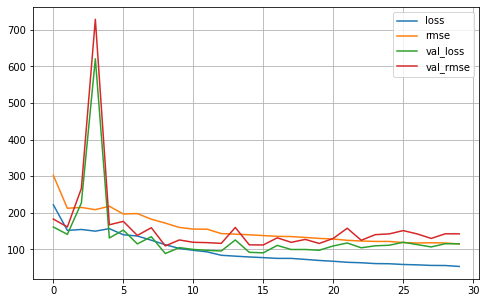

In [20]:
plot_train_history(unievo_hist, 'Training and validation loss')

In [61]:
unievo_test[1]

array([[188, 109,  47,  42,  27,  61, 155, 370, 485, 458, 310, 271],
       [109,  47,  42,  27,  61, 155, 370, 485, 458, 310, 271, 298],
       [ 47,  42,  27,  61, 155, 370, 485, 458, 310, 271, 298, 297],
       [ 42,  27,  61, 155, 370, 485, 458, 310, 271, 298, 297, 298],
       [ 27,  61, 155, 370, 485, 458, 310, 271, 298, 297, 298, 310],
       [ 61, 155, 370, 485, 458, 310, 271, 298, 297, 298, 310, 408],
       [155, 370, 485, 458, 310, 271, 298, 297, 298, 310, 408, 559],
       [370, 485, 458, 310, 271, 298, 297, 298, 310, 408, 559, 636],
       [485, 458, 310, 271, 298, 297, 298, 310, 408, 559, 636, 511],
       [458, 310, 271, 298, 297, 298, 310, 408, 559, 636, 511, 415],
       [310, 271, 298, 297, 298, 310, 408, 559, 636, 511, 415, 407],
       [271, 298, 297, 298, 310, 408, 559, 636, 511, 415, 407, 314],
       [298, 297, 298, 310, 408, 559, 636, 511, 415, 407, 314, 299],
       [297, 298, 310, 408, 559, 636, 511, 415, 407, 314, 299, 157],
       [298, 310, 408, 559, 636, 5

In [63]:
save_performance_to_txt("Evo_Single_Variable",
                         unievo_model.predict(unievo_test[0]),
                         unievo_test[1], unievo_eval)

[array([463.4176  , 389.02658 , 323.36472 , 208.51543 , 135.63782 ,
        92.06861 ,  59.630756,  57.968487, 115.795654, 223.1896  ,
       396.3718  , 496.79092 ], dtype=float32), array([332.0866 , 305.0957 , 302.05197, 377.75192, 463.76523, 550.8258 ,
       666.2656 , 650.3734 , 598.9169 , 481.24982, 416.87982, 317.55878],
      dtype=float32), array([299.3224  , 196.89473 , 104.262344,  50.50942 ,  20.207384,
        17.356012, 101.04029 , 276.56058 , 409.4541  , 474.87802 ,
       442.64294 , 370.56702 ], dtype=float32), array([322.15335, 310.00375, 314.76868, 397.62085, 495.95938, 570.91394,
       673.0816 , 644.1005 , 583.37885, 464.22147, 403.70053, 307.32358],
      dtype=float32)]
[463.4176   389.02658  323.36472  208.51543  135.63782   92.06861
  59.630756  57.968487 115.795654 223.1896   396.3718   496.79092
 332.0866   305.0957   302.05197  377.75192  463.76523  550.8258
 666.2656   650.3734   598.9169   481.24982  416.87982  317.55878
 299.3224   196.89473  104.262344 

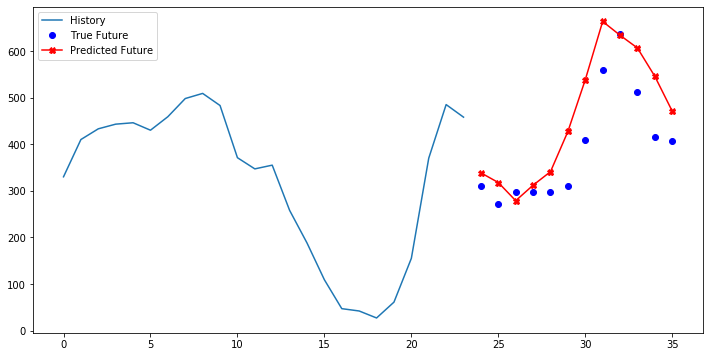

In [22]:
multi_step_plot(unievo_test[0][10], unievo_test[1][10], unievo_model.predict(np.array([unievo_test[0][10]])))

Evo Performance Univariavel (Hours Skiped = 12)


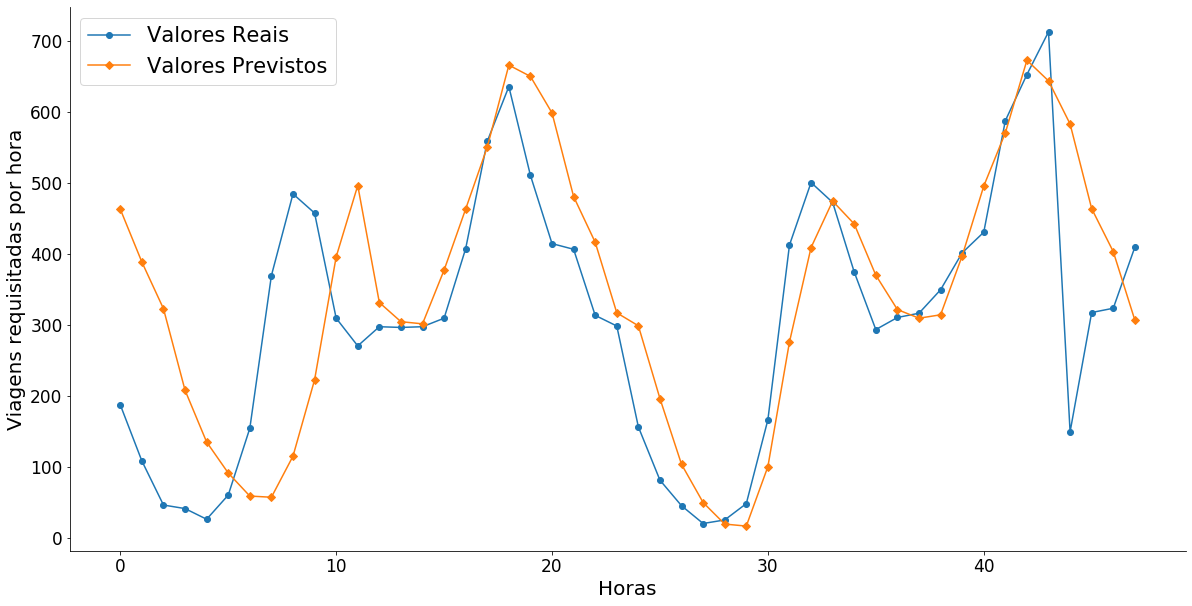

In [23]:
performance_representation_plot(12, 
                                "Evo Performance Univariavel",
                                unievo_model.predict(unievo_test[0]),
                                unievo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [24]:
print('Evo Model Multi Var')
evo_model, evo_hist, evo_test, evo_eval = run_lstm(evo_data,  24, 12, (0.6, 0.8), 100,
                                                   epochs=global_epoch_number, dropout=0.7, layer_count = 5)

Evo Model Multi Var
[136, 181]
[136, 181]
(45, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 16s 321ms/step - loss: 225.2985 - rmse: 296.4385 - val_loss: 169.1597 - val_rmse: 192.5390
Epoch 2/30
50/50 [==============================] - 10s 203ms/step - loss: 165.4041 - rmse: 226.6380 - val_loss: 225.3797 - val_rmse: 263.9405
Epoch 3/30
50/50 [==============================] - 10s 207ms/step - loss: 158.6463 - rmse: 219.9858 - val_loss: 154.9341 - val_rmse: 177.4175
Epoch 4/30
50/50 [==============================] - 10s 198ms/step - loss: 130.4450 - rmse: 190.8504 - val_loss: 125.4420 - val_rmse: 150.0991
Epoch 5/30
50/50 [==============================] - 10s 203ms/step - loss: 116.7842 - rmse: 176.4695 - val_loss: 107.9972 - val_rmse: 133.1771
Epoch 6/30
50/50 [==============================] - 10s 204ms/step - loss: 114.9321 - rmse: 175.9061 - val_loss: 99.1476 - val_rmse: 124.0557
Epoch 7/30
50/50 [==============================] 

In [25]:
evo_model.save(r'models/evo_model')

INFO:tensorflow:Assets written to: models/evo_model\assets


In [26]:
print(evo_eval)
print(eval_model(evo_test[1], persistance_model(evo_test[0], 12)))

{'RMSE': 160.23452979974212, 'MAE': 94.92528232241023, 'R2': 0.14727491454337135}
{'RMSE': 241.07871256536507, 'MAE': 197.78985507246375, 'R2': -0.9059816693374572}


### Plotting prediction

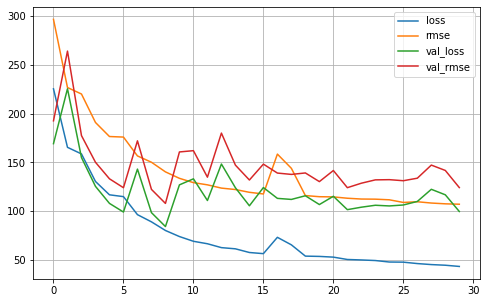

In [27]:
plot_train_history(evo_hist,
                   'Training and validation loss')

In [28]:
save_performance_to_txt("Evo_Multivariable",
                         evo_model.predict(evo_test[0]),
                         evo_test[1], evo_eval)


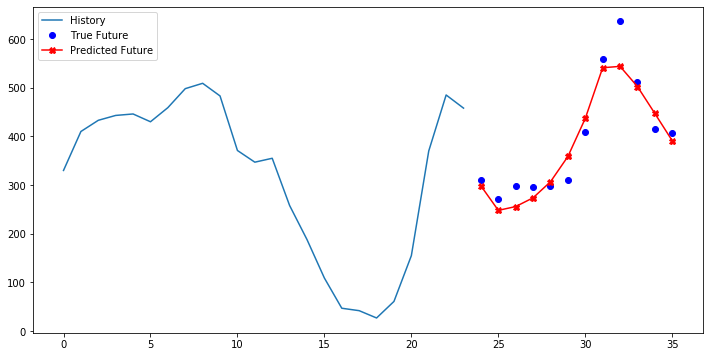

In [29]:
multi_step_plot(evo_test[0][10], evo_test[1][10], evo_model.predict(np.array([evo_test[0][10]])))

Evo Performance Multivariavel (Hours Skiped = 12)


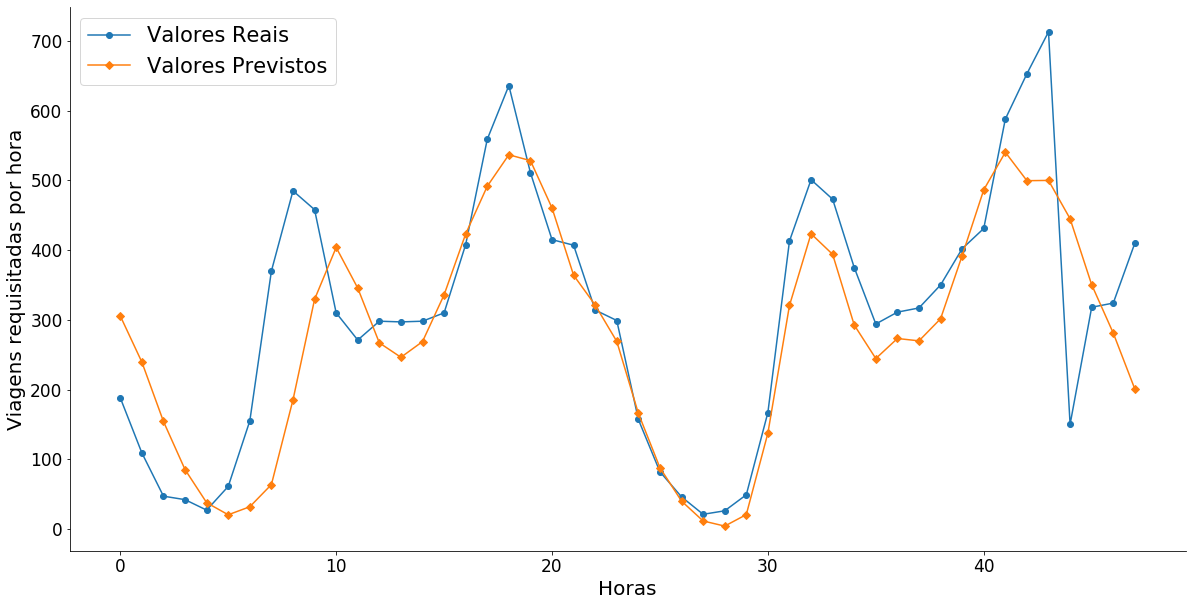

In [30]:
performance_representation_plot(12, 
                                "Evo Performance Multivariavel",
                                evo_model.predict(evo_test[0]),
                                evo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Modo model

### Single Variable

In [31]:
print('Modo Model')
unimodo_model, unimodo_hist, unimodo_test, unimodo_eval = run_lstm(unimodo_data, 24, 12, (0.6, 0.8), 60,
                                                          epochs=global_epoch_number, dropout=0.5, layer_count = 5)

Modo Model
[215, 287]
[215, 287]
(72, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 15s 295ms/step - loss: 29.2661 - rmse: 40.9329 - val_loss: 18.3882 - val_rmse: 23.6151
Epoch 2/30
50/50 [==============================] - 9s 179ms/step - loss: 20.5724 - rmse: 31.9080 - val_loss: 23.1244 - val_rmse: 29.8198
Epoch 3/30
50/50 [==============================] - 9s 185ms/step - loss: 16.9235 - rmse: 29.2627 - val_loss: 18.7016 - val_rmse: 24.8491
Epoch 4/30
50/50 [==============================] - 9s 182ms/step - loss: 15.2333 - rmse: 28.1758 - val_loss: 11.6734 - val_rmse: 16.3197
Epoch 5/30
50/50 [==============================] - 9s 187ms/step - loss: 13.9260 - rmse: 27.1213 - val_loss: 12.4589 - val_rmse: 17.5977
Epoch 6/30
50/50 [==============================] - 9s 187ms/step - loss: 12.6931 - rmse: 26.1519 - val_loss: 10.6297 - val_rmse: 14.5706
Epoch 7/30
50/50 [==============================] - 10s 203ms/step - loss: 11.5848 - rm

In [32]:
unimodo_model.save(r'models/unimodo_model')

INFO:tensorflow:Assets written to: models/unimodo_model\assets


In [33]:
print(unimodo_eval)
print(eval_model(unimodo_test[1], persistance_model(unimodo_test[0], 12)))

{'RMSE': 23.5587308903426, 'MAE': 15.378325667473726, 'R2': 0.2519943140561793}
{'RMSE': 38.957122678752945, 'MAE': 29.724537037037035, 'R2': -1.0510354200915273}


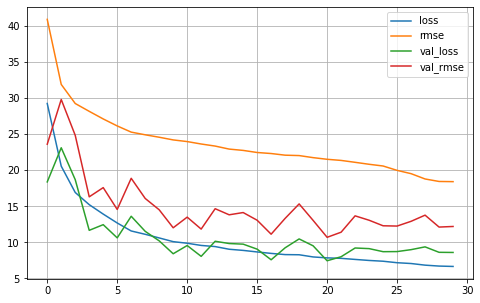

In [34]:
plot_train_history(unimodo_hist, 'Training and validation loss')

In [35]:
save_performance_to_txt("Modo_Single_Variable",
                         unimodo_model.predict(unimodo_test[0]),
                         unimodo_test[1], unimodo_eval)


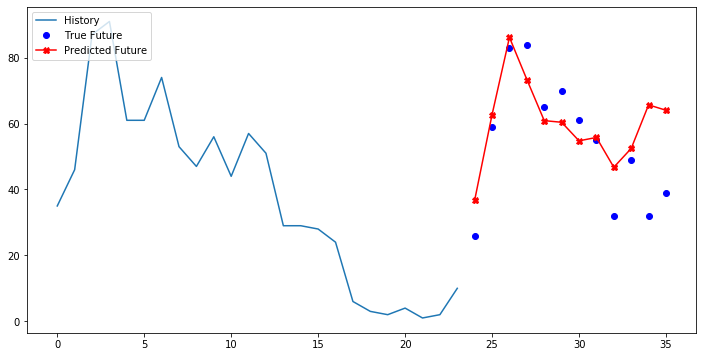

In [36]:
multi_step_plot(unimodo_test[0][10], unimodo_test[1][10], unimodo_model.predict(np.array([unimodo_test[0][10]])))

Modo Performance Univariavel (Hours Skiped = 12)


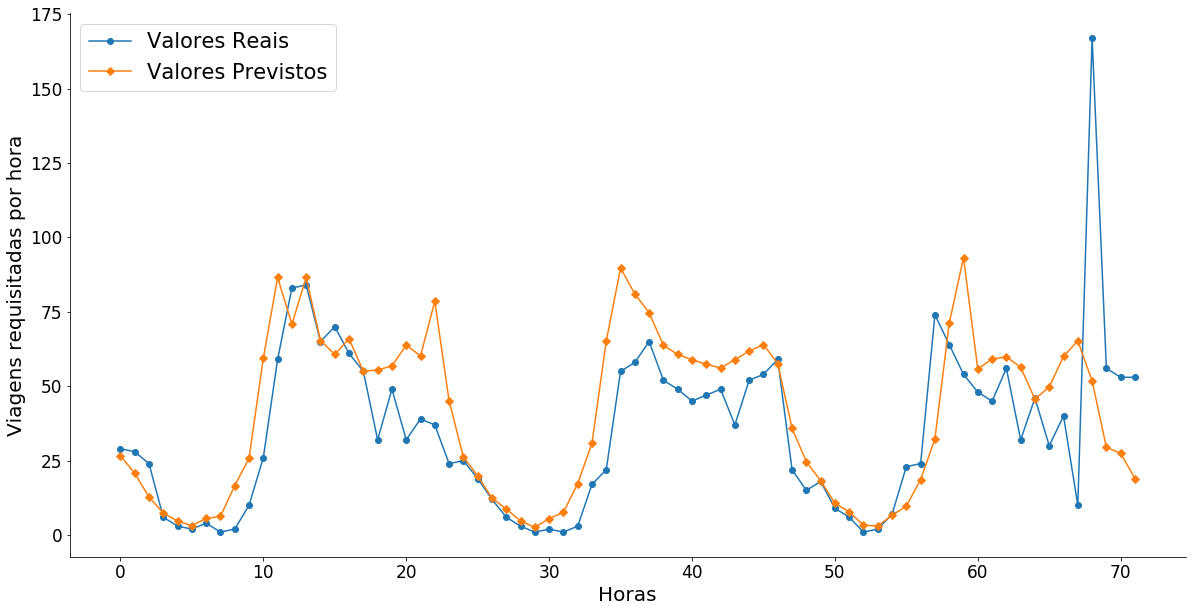

In [37]:
performance_representation_plot(12, 
                                "Modo Performance Univariavel",
                                unimodo_model.predict(unimodo_test[0]),
                                unimodo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [38]:
print('Modo Model')
modo_model, modo_hist, modo_test, modo_eval = run_lstm(modo_data, 24, 12, (0.6, 0.8), 100,
                                                       epochs=global_epoch_number, dropout=0.7, layer_count = 5)

Modo Model
[215, 287]
[215, 287]
(72, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 27s 537ms/step - loss: 32.1665 - rmse: 43.8973 - val_loss: 26.3900 - val_rmse: 33.6043
Epoch 2/30
50/50 [==============================] - 22s 436ms/step - loss: 23.1653 - rmse: 33.8246 - val_loss: 25.2600 - val_rmse: 31.9444
Epoch 3/30
50/50 [==============================] - 22s 449ms/step - loss: 20.4494 - rmse: 32.1833 - val_loss: 14.0161 - val_rmse: 18.7190
Epoch 4/30
50/50 [==============================] - 23s 460ms/step - loss: 15.2871 - rmse: 27.8946 - val_loss: 13.7843 - val_rmse: 18.9224
Epoch 5/30
50/50 [==============================] - 26s 518ms/step - loss: 12.6520 - rmse: 25.6407 - val_loss: 13.0592 - val_rmse: 17.5633
Epoch 6/30
50/50 [==============================] - 23s 468ms/step - loss: 11.3797 - rmse: 24.6834 - val_loss: 9.5976 - val_rmse: 13.6588
Epoch 7/30
50/50 [==============================] - 23s 463ms/step - loss: 10.4671 

In [39]:
modo_model.save(r'models/modo_model')

INFO:tensorflow:Assets written to: models/modo_model\assets


In [40]:
print(modo_eval)
print(eval_model(modo_test[1], persistance_model(modo_test[0], 12)))

{'RMSE': 26.450155581570566, 'MAE': 17.900805289977818, 'R2': 0.060296039305291156}
{'RMSE': 38.957122678752945, 'MAE': 29.724537037037035, 'R2': -1.0510354200915273}


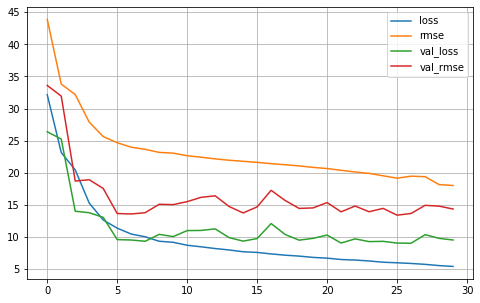

In [41]:
plot_train_history(modo_hist,
                   'Training and validation loss')

In [42]:
save_performance_to_txt("Modo_Multivariable",
                         modo_model.predict(modo_test[0]),
                         modo_test[1], modo_eval)


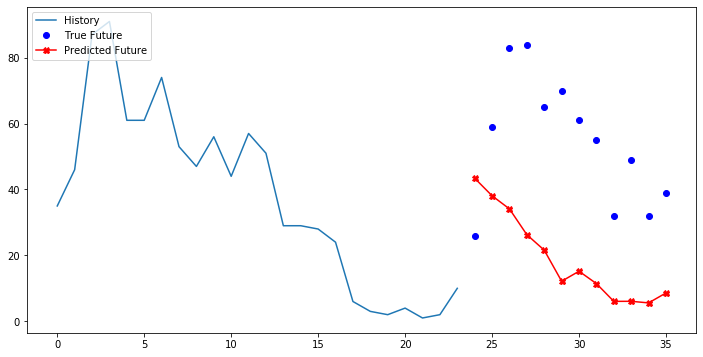

In [43]:
multi_step_plot(modo_test[0][10], modo_test[1][10], modo_model.predict(np.array([modo_test[0][10]])))

Modo Performance Multivariavel (Hours Skiped = 12)


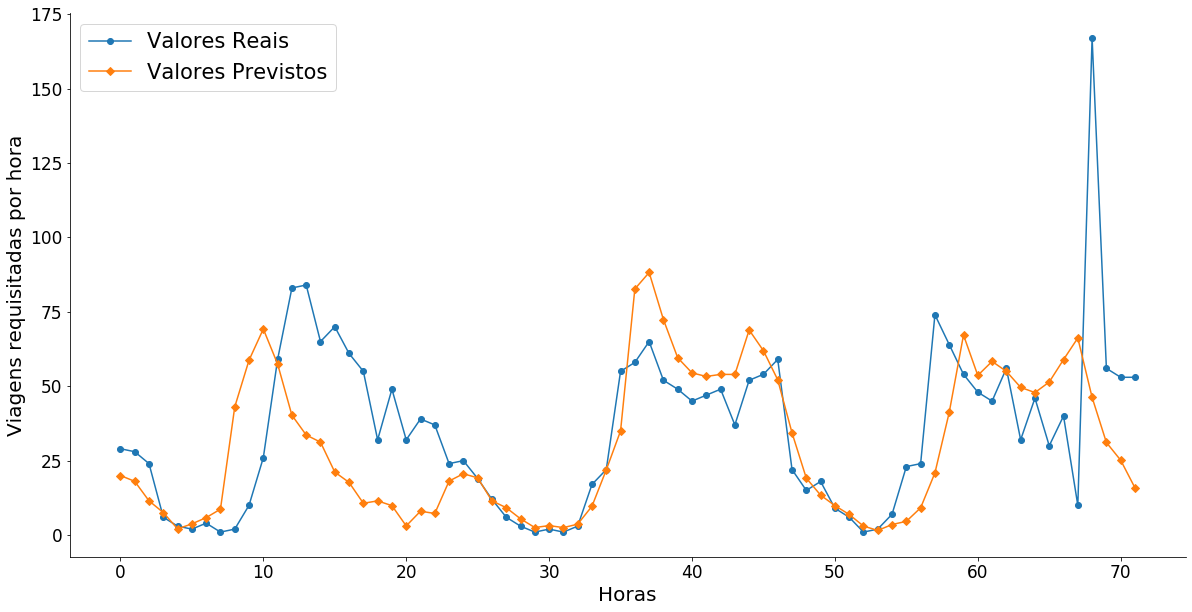

In [44]:
performance_representation_plot(12, 
                                "Modo Performance Multivariavel",
                                modo_model.predict(modo_test[0]),
                                modo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Car2Go Model

### Single Variable

In [45]:
print('Car2Go Model')
unic2g_model, unic2g_hist, unic2g_test, unic2g_eval = run_lstm(unic2g_data, 24, 12, (0.6, 0.8), 60,
                                                               epochs=global_epoch_number, dropout=0.5, layer_count = 5)

Car2Go Model
[241, 322]
[241, 322]
(81, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 23s 453ms/step - loss: 140.3962 - rmse: 169.0180 - val_loss: 85.7695 - val_rmse: 102.9850
Epoch 2/30
50/50 [==============================] - 17s 337ms/step - loss: 94.0915 - rmse: 115.1988 - val_loss: 91.9367 - val_rmse: 114.5877
Epoch 3/30
50/50 [==============================] - 17s 336ms/step - loss: 82.2398 - rmse: 102.5918 - val_loss: 96.6685 - val_rmse: 123.1577
Epoch 4/30
50/50 [==============================] - 17s 337ms/step - loss: 69.3814 - rmse: 89.3829 - val_loss: 49.0396 - val_rmse: 60.3472
Epoch 5/30
50/50 [==============================] - 17s 337ms/step - loss: 59.4900 - rmse: 78.7313 - val_loss: 51.4162 - val_rmse: 64.8928
Epoch 6/30
50/50 [==============================] - 17s 333ms/step - loss: 55.6325 - rmse: 73.5770 - val_loss: 71.7205 - val_rmse: 97.4565
Epoch 7/30
50/50 [==============================] - 17s 337ms/step - loss

In [46]:
unic2g_model.save(r'models/unic2g_model')

INFO:tensorflow:Assets written to: models/unic2g_model\assets


In [47]:
print(unic2g_eval)
print(eval_model(unic2g_test[1], persistance_model(unic2g_test[0], 12)))

{'RMSE': 48.704347240513506, 'MAE': 36.44222982319784, 'R2': 0.7719889342746735}
{'RMSE': 148.40249809329094, 'MAE': 121.52983539094652, 'R2': -1.1362649026830889}


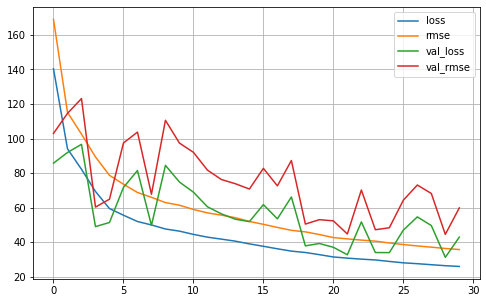

In [48]:
plot_train_history(unic2g_hist,
                   'Training and validation loss')

In [49]:
save_performance_to_txt("Car2Go_Single_Variable",
                         unic2g_model.predict(unic2g_test[0]),
                         unic2g_test[1], unic2g_eval)

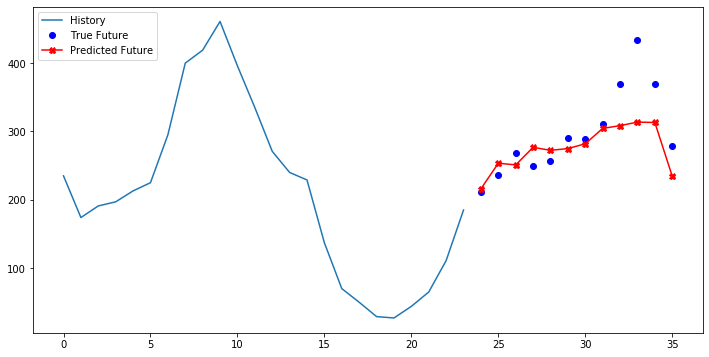

In [50]:
multi_step_plot(unic2g_test[0][10], unic2g_test[1][10], unic2g_model.predict(np.array([unic2g_test[0][10]])))

Car2Go Performance Univariável (Hours Skiped = 12)


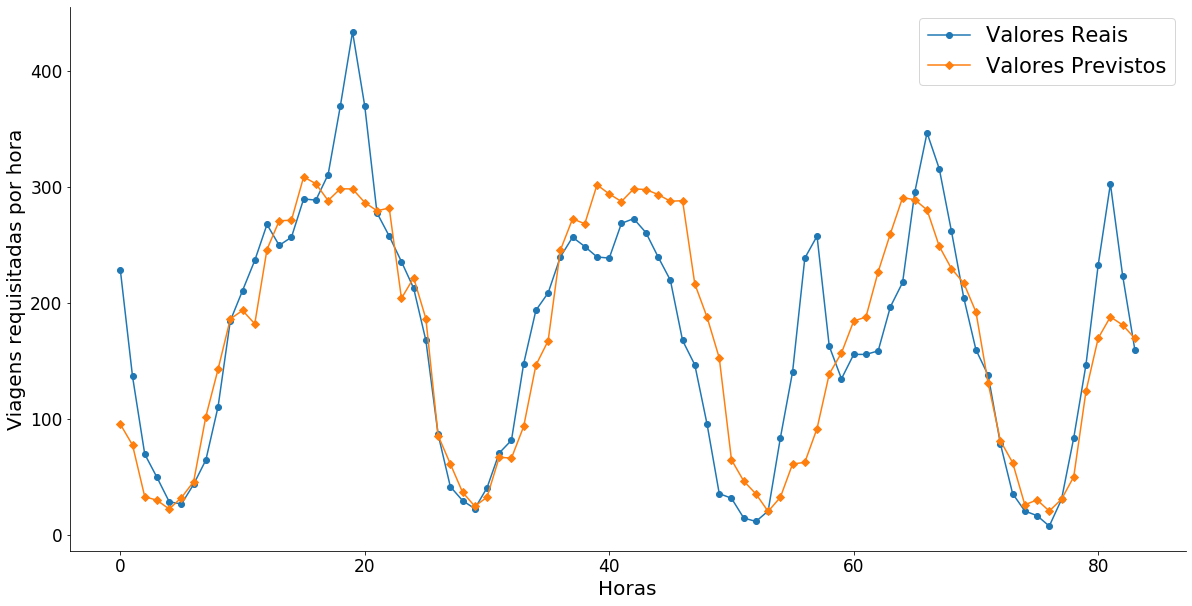

In [51]:
performance_representation_plot(12, 
                                "Car2Go Performance Univariável",
                                unic2g_model.predict(unic2g_test[0]),
                                unic2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [52]:
print('Car2Go Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 100,
                                                   epochs=global_epoch_number, dropout=0.7, layer_count = 5)

Car2Go Model
[241, 322]
[241, 322]
(81, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 33s 669ms/step - loss: 1575.1573 - rmse: 1999.1658 - val_loss: 174.5064 - val_rmse: 217.1573
Epoch 2/30
50/50 [==============================] - 29s 588ms/step - loss: 177.0196 - rmse: 221.9405 - val_loss: 128.1086 - val_rmse: 161.4540
Epoch 3/30
50/50 [==============================] - 30s 595ms/step - loss: 98.3192 - rmse: 120.4005 - val_loss: 120.0049 - val_rmse: 146.7731
Epoch 4/30
50/50 [==============================] - 30s 603ms/step - loss: 112.1486 - rmse: 137.3280 - val_loss: 85.9972 - val_rmse: 105.9284
Epoch 5/30
50/50 [==============================] - 32s 633ms/step - loss: 96.3500 - rmse: 119.3200 - val_loss: 98.7220 - val_rmse: 123.5791
Epoch 6/30
50/50 [==============================] - 31s 620ms/step - loss: 76.1642 - rmse: 95.6263 - val_loss: 88.6220 - val_rmse: 113.6396
Epoch 7/30
50/50 [==============================] - 32s 632ms

In [53]:
c2g_model.save(r'models/c2g_model')

INFO:tensorflow:Assets written to: models/c2g_model\assets


In [54]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 40.20465306366417, 'MAE': 27.905730649767587, 'R2': 0.843791501717876}
{'RMSE': 148.40249809329094, 'MAE': 121.52983539094652, 'R2': -1.1362649026830889}


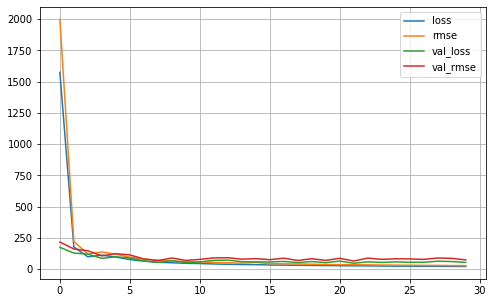

In [55]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [56]:
save_performance_to_txt("Car2Go_Multivariable",
                         c2g_model.predict(c2g_test[0]),
                         c2g_test[1], c2g_eval)

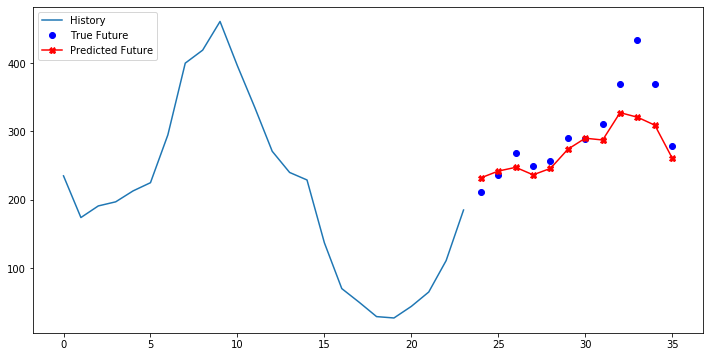

In [57]:
multi_step_plot(c2g_test[0][10], c2g_test[1][10], c2g_model.predict(np.array([c2g_test[0][10]])))

Car2Go Performance Multivariavel (Hours Skiped = 12)


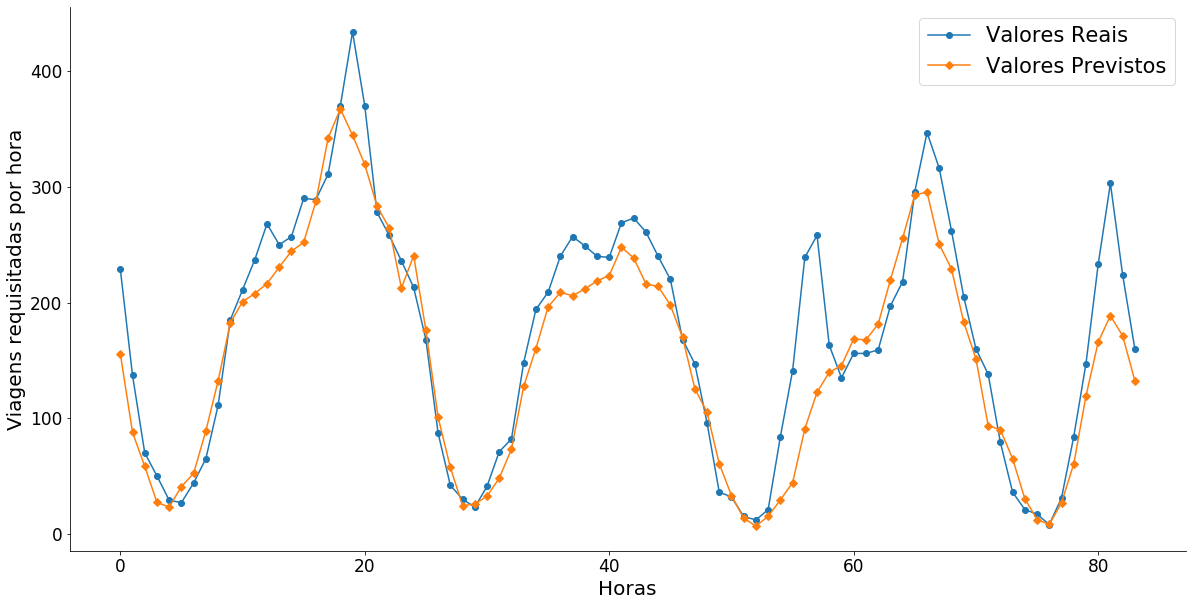

In [58]:
performance_representation_plot(12, 
                                "Car2Go Performance Multivariavel",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Comparison Tables

In [59]:
evo_table = pd.DataFrame(data={"uni":unievo_eval, "multi":evo_eval})


performance_representation_plotrences

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/